In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pywt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tensorflow as tf

torch.manual_seed(10)

In [2]:
data = pd.read_csv('index_data/near_20_years.csv') 

raw_data = data['AClose^GSPC']

# time delay
tau = 3
# Embedded dimension
m = 5


index = []
data = []
for i in range(len(raw_data)):
     x, y = i, raw_data[i]
     X = float(x)
     Y = float(y)
     index.append(X)
     data.append(Y)

maximum level is 10


<Figure size 432x288 with 0 Axes>

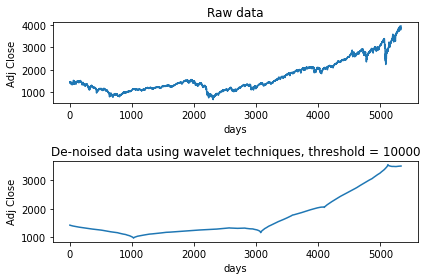

In [3]:
# Create wavelet object and define parameters
w = pywt.Wavelet('coif1')
maxlev = pywt.dwt_max_level(len(data), w.dec_len)
#maxlev = 2 # Override if desired
print("maximum level is " + str(maxlev))
threshold = 10000 # Threshold for filtering

# Decompose into wavelet components, to the level selected:
coeffs = pywt.wavedec(data, 'coif1', level=maxlev)


plt.figure()
for i in range(1, len(coeffs)):
     #plt.subplot(maxlev, 1, i)
     #plt.plot(coeffs[i])
     coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
     #plt.plot(coeffs[i])


datarec = pywt.waverec(coeffs, 'coif1')

datarec

mintime = 1
maxtime = len(raw_data)

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(index[mintime:maxtime], data[mintime:maxtime])
plt.xlabel('days')
plt.ylabel('Adj Close')
plt.title("Raw data")
plt.subplot(2, 1, 2)
plt.plot(index[mintime:maxtime], datarec[mintime:maxtime])
plt.xlabel('days')
plt.ylabel('Adj Close')
plt.title("De-noised data using wavelet techniques" + ", threshold = " +str(threshold))

plt.tight_layout()
plt.show()

In [4]:
datarec

array([1416.81155747, 1418.36994758, 1420.49090945, ..., 3511.23528656,
       3511.39505106, 3511.54816721])

In [5]:

ps_data = []
for i in range( len(datarec) - (m-1)*tau  ):
    delayTime = []
    for j in range( m ):
        delayTime.append( datarec[i + j * tau ] )
    ps_data.append(delayTime)

ps_data = pd.DataFrame(ps_data)

ps_data

,0,1,2,3,4
0,1416.811557,1418.536061,1414.353156,1411.533242,1409.127109
1,1418.369948,1416.883627,1413.463446,1410.460766,1408.407289
2,1420.490909,1415.663686,1412.550408,1409.810140,1407.705060
3,1418.536061,1414.353156,1411.533242,1409.127109,1406.899902
4,1416.883627,1413.463446,1410.460766,1408.407289,1406.111917
...,...,...,...,...,...
5317,3509.649931,3509.941369,3510.264825,3510.639714,3510.973483
5318,3509.722426,3510.041079,3510.390501,3510.752191,3511.070392
5319,3509.833011,3510.136509,3510.514069,3510.867168,3511.235287
5320,3509.941369,3510.264825,3510.639714,3510.973483,3511.395051


In [6]:
mm = MinMaxScaler()


ps_data_normalized = mm.fit_transform(ps_data )
#ps_data_normalized = preprocessing.normalize(ps_data.T , norm='l2').T
#ps_data_origin = mm.inverse_transform( mm.fit_transform(ps_data ) )

ps_data_normalized = mm.inverse_transform(ps_data_normalized)

train_data = ps_data_normalized[0 : int(len(ps_data_normalized)*0.8) ]
train_ans = df = pd.DataFrame(np.zeros((1, m)))
train_ans = pd.concat([train_ans, pd.DataFrame(ps_data_normalized)]).drop([0]).to_numpy()
test_data = ps_data_normalized[ int(len(ps_data_normalized)*0.8) : len(ps_data_normalized) ]

train_data = torch.Tensor(train_data)

In [7]:
train_ans

array([[1418.36994758, 1416.88362708, 1413.46344569, 1410.46076635,
        1408.40728891],
       [1420.49090945, 1415.66368588, 1412.550408  , 1409.81014035,
        1407.70505997],
       [1418.53606102, 1414.3531562 , 1411.53324163, 1409.12710869,
        1406.89990211],
       ...,
       [3509.83301111, 3510.13650922, 3510.51406907, 3510.86716773,
        3511.23528656],
       [3509.94136942, 3510.26482477, 3510.63971372, 3510.97348321,
        3511.39505106],
       [3510.04107896, 3510.39050082, 3510.75219132, 3511.07039179,
        3511.54816721]])

In [8]:
train_data

tensor([[1416.8115, 1418.5360, 1414.3531, 1411.5332, 1409.1271],
        [1418.3700, 1416.8837, 1413.4635, 1410.4608, 1408.4073],
        [1420.4910, 1415.6637, 1412.5504, 1409.8102, 1407.7051],
        ...,
        [2298.5562, 2302.4067, 2306.3352, 2310.2925, 2314.2405],
        [2299.8411, 2303.6768, 2307.6558, 2311.6079, 2315.5559],
        [2301.1279, 2305.0083, 2308.9778, 2312.9243, 2316.8716]])

In [9]:

batch = 16
input_size = m
#timestep_size = 5
hidden_size = 32
Hidden_layers = 3
Dropout = 0.6
output_size = 1
learning_rate = 0.001
torch.manual_seed(0)
timestep_size = 1

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, Hidden_layers, dropout ):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = Hidden_layers,
            dropout = dropout 
        )
        self.out = nn.Sequential(

            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 5),
            #nn.Tanh(),
        )

    def forward(self, _x):
        x, _ = self.rnn(_x)     # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape       # x is output, size (seq_len, batch, hidden_size)
        x = x.view(s * b, h)
        x = self.out(x)
        x = x.view(s, b, -1)    # 把形状改回来
        return x 

def Loss(out, y):
    ans = 0
    for i in range(len(out)):
        ans += (out[i].detach().numpy()-y[i])**2
    return ans / len(out)


model = RNN(input_size, hidden_size, Hidden_layers, Dropout)
criterion = nn.MSELoss(reduction = 'sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(30): 
    mean_loss = 0
    for i in range( len(train_data) ):
        input_x = []
       # try:
        if True:
            for j in range(i, i + timestep_size):
                input_x.append(train_data[j])
                
            optimizer.zero_grad()
            input_x = torch.tensor([item.cpu().detach().numpy() for item in input_x])
            input_x = tf.reshape(input_x, [timestep_size, -1, input_size ]).numpy()
            output = model( torch.from_numpy(input_x) )
            # if i <= 10:
            #      print( output.flatten())
            #      print( train_ans[i+1])
            loss = criterion( output.requires_grad_(True).double(), torch.tensor(train_ans[i+1]).double() )
            mean_loss += loss.item()
            loss.backward()
            optimizer.step()
        #except:
        #    print("Something wrong")
        #    continue
    print( ">>> loss : " + str(mean_loss/len(train_data)) )

C:\Users\ggg59\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([1, 1, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
>>> loss : 3230812.496927869
>>> loss : 182859.20999291015
>>> loss : 111592.02439354108
>>> loss : 203247.61491880345
>>> loss : 421398.51873772556
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
  File "C:\Users\ggg59\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-f44218eca

TypeError: object of type 'NoneType' has no len()

In [34]:
pred = np.zeros(4257)
for i in range( len(train_data) ):
    input_x = []
    input_x.append(train_data[j])
    input_x = torch.tensor([item.cpu().detach().numpy() for item in input_x])
    input_x = tf.reshape(input_x, [timestep_size, -1, input_size ]).numpy()
    output = model( torch.from_numpy(input_x) )
    print( output.flatten())
    for j in range(len(output)):
        pred[i + j * tau] = output.detach().numpy()[0][0][j]



.1027, 1748.2551],
       grad_fn=<ViewBackward>)
tensor([1743.7173, 1744.8317, 1745.9622, 1747.1027, 1748.2551],
       grad_fn=<ViewBackward>)
tensor([1743.7173, 1744.8317, 1745.9622, 1747.1027, 1748.2551],
       grad_fn=<ViewBackward>)
tensor([1743.7173, 1744.8317, 1745.9622, 1747.1027, 1748.2551],
       grad_fn=<ViewBackward>)
tensor([1743.7173, 1744.8317, 1745.9622, 1747.1027, 1748.2551],
       grad_fn=<ViewBackward>)
tensor([1743.7173, 1744.8317, 1745.9622, 1747.1027, 1748.2551],
       grad_fn=<ViewBackward>)
tensor([1743.7173, 1744.8317, 1745.9622, 1747.1027, 1748.2551],
       grad_fn=<ViewBackward>)
tensor([1743.7173, 1744.8317, 1745.9622, 1747.1027, 1748.2551],
       grad_fn=<ViewBackward>)
tensor([1743.7173, 1744.8317, 1745.9622, 1747.1027, 1748.2551],
       grad_fn=<ViewBackward>)
tensor([1743.7173, 1744.8317, 1745.9622, 1747.1027, 1748.2551],
       grad_fn=<ViewBackward>)
tensor([1743.7173, 1744.8317, 1745.9622, 1747.1027, 1748.2551],
       grad_fn=<ViewBackward>)


In [32]:
output.detach().numpy()[0][0]

array([1743.7173, 1744.8317, 1745.9622, 1747.1027, 1748.2551],
      dtype=float32)

Text(0, 0.5, 'Adj Close')

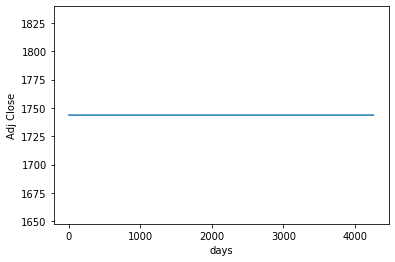

In [36]:
plt.plot(index[mintime:int(maxtime*0.8)-10], pred[mintime:int(maxtime*0.8)] )
plt.xlabel('days')
plt.ylabel('Adj Close')

In [9]:
#MLP
batch = 16
input_size = m
#timestep_size = 5
hidden_size = 32
Hidden_layers = 3
Dropout = 0.6
output_size = 1
learning_rate = 0.001
Epoch = 30

class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size,64),
            nn.Linear(64,64),
            nn.Linear(64,32),
            nn.Linear(32,32),
            nn.Linear(32,16),
            nn.Linear(16,16),
            nn.Linear(16,16),
            nn.Linear(16,input_size)
        )
        
        
    def forward(self,x):
        x = x.view(-1,input_size)
        # dout = F.tanh(self.fc1(din))
        # dout = F.tanh(self.fc2(dout))
        # dout = F.tanh(self.fc3(dout))
        # dout = F.tanh(self.fc4(dout))
        # dout = F.tanh(self.fc5(dout))
        # dout = F.tanh(self.fc6(dout))
        # dout = F.tanh(self.fc7(dout))
        #return F.tanh(self.fc8(dout))
        x = self.layers(x)
        return x

model = MLP()
print(model)
criterion = nn.MSELoss(reduction = 'sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(Epoch):
    mean_loss = 0
    for i in range( len(train_data) ):
        optimizer.zero_grad()
        inputs = torch.autograd.Variable( torch.tensor(train_data[i]))
        labels = torch.autograd.Variable( torch.tensor(train_ans[i+1]))
        outputs = model(inputs)
        if i == 0:
            print( train_data[i])
            print( train_ans[i+1])
            print(outputs)
        loss = criterion( outputs.double().flatten(), labels.double() )
        mean_loss += loss.item()
        loss.backward()
        optimizer.step()
    print( mean_loss/len(train_data) )



MLP(
  (layers): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): Linear(in_features=16, out_features=16, bias=True)
    (6): Linear(in_features=16, out_features=16, bias=True)
    (7): Linear(in_features=16, out_features=5, bias=True)
  )
)
tensor([1416.8115, 1418.5360, 1414.3531, 1411.5332, 1409.1271])
[1420.49090945 1415.66368588 1412.550408   1409.81014035 1407.70505997]
tensor([[-18.8257,  -2.9659,  21.2632,   8.4978,  -0.9320]],
       grad_fn=<AddmmBackward>)
ERROR! Session/line number was not unique in database. History logging moved to new session 143
ipykernel_launcher:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requi

KeyboardInterrupt: 